# 01 PV data exploration

## PV Data Exploration for E-Auto Charging Optimization
### Analysis of solar surplus patterns for optimal EV charging windows

### 0. Setup

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
import sys
from pathlib import Path

# Add src to path for imports
sys.path.append('../src')

# Settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
warnings.filterwarnings('ignore')

print("🚗⚡ PV Data Exploration for E-Auto Charging Optimization")
print("=" * 60)



🚗⚡ PV Data Exploration for E-Auto Charging Optimization


# 1. DATA LOADING AND BASIC OVERVIEW

In [16]:
print("\n1. 📊 LOADING AND BASIC DATA OVERVIEW")
print("-" * 40)

# Load PV data using the loader function
df = pd.read_csv("../data/raw/pv_data.csv", sep=";")

if df is None:
    print("❌ Could not load data. Please check that CSV files are in ../data/raw/")
    exit()

print(f"✅ Data loaded successfully!")

# Safe datetime index check and conversion
print("🔍 Checking datetime index...")
if not pd.api.types.is_datetime64_any_dtype(df.index):
    print("⚠️ Index is not datetime - attempting to fix...")

    # Look for timestamp column
    timestamp_cols = [col for col in df.columns if any(word in col.lower() for word in ['time', 'date', 'stamp'])]

    if timestamp_cols:
        timestamp_col = timestamp_cols[0]
        print(f"📅 Found timestamp column: {timestamp_col}")
        df['timestamp'] = pd.to_datetime(df[timestamp_col])
        df.set_index('timestamp', inplace=True)
        if timestamp_col in df.columns:
            df.drop(columns=[timestamp_col], inplace=True)
        print("✅ Converted to datetime index")
    else:
        print("🔧 Creating artificial datetime index (15-min intervals)...")
        start_date = pd.Timestamp('2022-01-01')
        df.index = pd.date_range(start=start_date, periods=len(df), freq='15min')
        print("✅ Created datetime index")

# Safe duration calculation
def safe_duration_calc(df):
    """Safely calculate duration and records per day"""
    try:
        if pd.api.types.is_datetime64_any_dtype(df.index):
            duration = (df.index.max() - df.index.min()).days
            if duration > 0:
                records_per_day = len(df) / duration
                return duration, records_per_day
    except:
        pass

    # Fallback: estimate based on typical 15-min intervals
    estimated_days = len(df) / 96  # 96 = 24 hours * 4 (15-min intervals)
    return estimated_days, 96

duration_days, records_per_day = safe_duration_calc(df)

# Print info with safe calculations
try:
    print(f"📅 Date range: {df.index.min()} to {df.index.max()}")
except:
    print(f"📅 Date range: Not available (non-datetime index)")

print(f"📈 Total records: {len(df):,}")
print(f"⏱️ Duration: {duration_days:.1f} days")
print(f"🔄 Frequency: ~{records_per_day:.0f} records/day")

# Basic info
print(f"\n📋 Dataset Info:")
print(f"   Shape: {df.shape}")
print(f"   Index type: {type(df.index)}")
print(f"   Index dtype: {df.index.dtype}")
print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Column overview
print(f"\n📊 Available columns:")
for i, col in enumerate(df.columns, 1):
    missing_pct = (df[col].isnull().sum() / len(df)) * 100
    print(f"   {i:2d}. {col:<35} (Missing: {missing_pct:5.1f}%)")

# Basic statistics
print(f"\n📈 Key Variables Summary:")
key_vars = ['Solarproduktion', 'Hausverbrauch', 'Ladezustand', 'Wallbox Gesamtladeleistung']
for var in key_vars:
    if var in df.columns:
        stats = df[var].describe()
        print(f"   {var}:")
        print(f"      Mean: {stats['mean']:8.1f} | Std: {stats['std']:8.1f}")
        print(f"      Min:  {stats['min']:8.1f} | Max: {stats['max']:8.1f}")

print(f"\n🎯 Data loading completed successfully!")


1. 📊 LOADING AND BASIC DATA OVERVIEW
----------------------------------------
✅ Data loaded successfully!
🔍 Checking datetime index...
⚠️ Index is not datetime - attempting to fix...
📅 Found timestamp column: timestamp
✅ Converted to datetime index
📅 Date range: 2022-02-07 14:00:00 to 2025-06-16 23:45:00
📈 Total records: 113,800
⏱️ Duration: 1225.0 days
🔄 Frequency: ~93 records/day

📋 Dataset Info:
   Shape: (113800, 15)
   Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
   Index dtype: datetime64[ns]
   Memory usage: 13.9 MB

📊 Available columns:
    1. Ladezustand                         (Missing:   0.0%)
    2. Batterie (Laden)                    (Missing:   0.0%)
    3. Batterie (Entladen)                 (Missing:   0.0%)
    4. Netzeinspeisung                     (Missing:   0.0%)
    5. Netzbezug                           (Missing:   0.0%)
    6. Solarproduktion Tracker 1           (Missing:   0.0%)
    7. Solarproduktion Tracker 2           (Missing:   0.0%)


# 2. E-AUTO CHARGING OPTIMIZATION: TARGET VARIABLE CREATION

In [17]:

print("\n\n2. 🚗 E-AUTO CHARGING OPTIMIZATION: TARGET VARIABLES")
print("-" * 50)

# Calculate energy surplus (available for EV charging)
df['energy_surplus'] = df['Solarproduktion'] - df['Hausverbrauch']

# Define EV charging quality classes based on available surplus
def classify_charging_quality(surplus_kw):
    """
    Classify time periods by their suitability for EV charging

    Classes:
    - Optimal: ≥3 kW surplus (fast charging possible)
    - Good: 1-3 kW surplus (slow charging possible)
    - Poor: <1 kW surplus (grid power needed)
    """
    if surplus_kw >= 3.0:
        return 'Optimal'
    elif surplus_kw >= 1.0:
        return 'Good'
    else:
        return 'Poor'

df['charging_quality'] = df['energy_surplus'].apply(classify_charging_quality)

# Binary classification for simplicity
df['charging_optimal'] = (df['energy_surplus'] >= 3.0).astype(int)

print("🎯 Charging Quality Classification:")
print("   Optimal: ≥3 kW surplus (fast EV charging)")
print("   Good:    1-3 kW surplus (slow EV charging)")
print("   Poor:    <1 kW surplus (grid power needed)")

# Class distribution
charging_dist = df['charging_quality'].value_counts()
charging_pct = df['charging_quality'].value_counts(normalize=True) * 100

print(f"\n📊 Charging Quality Distribution:")
for quality in ['Optimal', 'Good', 'Poor']:
    if quality in charging_dist:
        count = charging_dist[quality]
        pct = charging_pct[quality]
        print(f"   {quality:8s}: {count:6,} ({pct:5.1f}%)")

# Surplus statistics
print(f"\n⚡ Energy Surplus Statistics:")
surplus_stats = df['energy_surplus'].describe()
print(f"   Mean surplus: {surplus_stats['mean']:6.2f} kW")
print(f"   Std surplus:  {surplus_stats['std']:6.2f} kW")
print(f"   Min surplus:  {surplus_stats['min']:6.2f} kW")
print(f"   Max surplus:  {surplus_stats['max']:6.2f} kW")
print(f"   Times with surplus >0: {(df['energy_surplus'] > 0).sum():,} ({(df['energy_surplus'] > 0).mean()*100:.1f}%)")
print(f"   Times with surplus ≥3kW: {(df['energy_surplus'] >= 3).sum():,} ({(df['energy_surplus'] >= 3).mean()*100:.1f}%)")



2. 🚗 E-AUTO CHARGING OPTIMIZATION: TARGET VARIABLES
--------------------------------------------------
🎯 Charging Quality Classification:
   Optimal: ≥3 kW surplus (fast EV charging)
   Good:    1-3 kW surplus (slow EV charging)
   Poor:    <1 kW surplus (grid power needed)

📊 Charging Quality Distribution:
   Optimal : 43,045 ( 37.8%)
   Good    :    157 (  0.1%)
   Poor    : 70,598 ( 62.0%)

⚡ Energy Surplus Statistics:
   Mean surplus: 170.02 kW
   Std surplus:  500.93 kW
   Min surplus:  -2350.00 kW
   Max surplus:  2211.00 kW
   Times with surplus >0: 43,202 (38.0%)
   Times with surplus ≥3kW: 43,045 (37.8%)


# 3. TEMPORAL PATTERNS ANALYSIS

In [8]:
print("\n\n3. ⏰ TEMPORAL PATTERNS FOR OPTIMAL CHARGING")
print("-" * 45)

# Add time features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.day_of_week
df['month'] = df.index.month
df['season'] = df['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
})
df['is_weekend'] = df['day_of_week'].isin([5, 6])

# Hourly patterns
hourly_optimal = df.groupby('hour')['charging_optimal'].agg(['mean', 'count']).round(3)
hourly_optimal.columns = ['optimal_rate', 'total_periods']

print("🕐 Hourly Optimal Charging Rates:")
print("   Hour | Optimal Rate | Total Periods")
print("   -----|--------------|---------------")
for hour in range(24):
    if hour in hourly_optimal.index:
        rate = hourly_optimal.loc[hour, 'optimal_rate'] * 100
        count = hourly_optimal.loc[hour, 'total_periods']
        print(f"   {hour:2d}:00|    {rate:6.1f}%   |   {count:8,}")

# Find best charging hours
best_hours = hourly_optimal.sort_values('optimal_rate', ascending=False).head(5)
print(f"\n⭐ Top 5 Hours for Optimal EV Charging:")
for hour, data in best_hours.iterrows():
    rate = data['optimal_rate'] * 100
    print(f"   {hour:2d}:00 - {rate:5.1f}% optimal")

# Monthly patterns
monthly_optimal = df.groupby('month')['charging_optimal'].mean() * 100
print(f"\n📅 Monthly Optimal Charging Rates:")
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month_num in range(1, 13):
    if month_num in monthly_optimal.index:
        rate = monthly_optimal[month_num]
        print(f"   {months[month_num-1]}: {rate:5.1f}%")

# Seasonal patterns
seasonal_optimal = df.groupby('season')['charging_optimal'].mean() * 100
print(f"\n🌍 Seasonal Optimal Charging Rates:")
for season in ['Spring', 'Summer', 'Autumn', 'Winter']:
    if season in seasonal_optimal.index:
        rate = seasonal_optimal[season]
        print(f"   {season:6s}: {rate:5.1f}%")

# Weekend vs Weekday
weekend_optimal = df.groupby('is_weekend')['charging_optimal'].mean() * 100
print(f"\n📆 Weekday vs Weekend Optimal Charging:")
print(f"   Weekday: {weekend_optimal[False]:5.1f}%")
print(f"   Weekend: {weekend_optimal[True]:5.1f}%")




3. ⏰ TEMPORAL PATTERNS FOR OPTIMAL CHARGING
---------------------------------------------
🕐 Hourly Optimal Charging Rates:
   Hour | Optimal Rate | Total Periods
   -----|--------------|---------------
    0:00|       0.0%   |      4,740
    1:00|       0.0%   |      4,740
    2:00|       0.0%   |      4,740
    3:00|       0.0%   |      4,740
    4:00|       0.0%   |      4,740
    5:00|       4.7%   |      4,740
    6:00|      24.0%   |      4,740
    7:00|      40.0%   |      4,740
    8:00|      53.0%   |      4,740
    9:00|      67.4%   |      4,740
   10:00|      79.9%   |      4,740
   11:00|      87.1%   |      4,740
   12:00|      87.5%   |      4,740
   13:00|      88.0%   |      4,740
   14:00|      87.9%   |      4,744
   15:00|      83.4%   |      4,744
   16:00|      73.6%   |      4,744
   17:00|      59.0%   |      4,744
   18:00|      44.0%   |      4,744
   19:00|      23.3%   |      4,744
   20:00|       5.2%   |      4,744
   21:00|       0.0%   |      4,744
   2

# 4. WALLBOX DATA ANALYSIS (if available)

In [9]:
print("\n\n4. 🔌 WALLBOX DATA ANALYSIS")
print("-" * 30)

wallbox_col = 'Wallbox Gesamtladeleistung'
if wallbox_col in df.columns:
    # Remove missing values for wallbox analysis
    df_wallbox = df[df[wallbox_col].notna()].copy()

    print(f"✅ Wallbox data available!")
    print(f"📊 Coverage: {len(df_wallbox):,} / {len(df):,} ({len(df_wallbox)/len(df)*100:.1f}%)")

    # When was the wallbox actually used?
    df_wallbox['wallbox_active'] = df_wallbox[wallbox_col] > 0.5  # 0.5 kW threshold

    active_periods = df_wallbox['wallbox_active'].sum()
    total_periods = len(df_wallbox)

    print(f"🚗 Wallbox usage patterns:")
    print(f"   Active periods: {active_periods:,} / {total_periods:,} ({active_periods/total_periods*100:.1f}%)")

    if active_periods > 0:
        # When was the wallbox used vs. when was it optimal?
        wallbox_usage = df_wallbox.groupby('hour').agg({
            'wallbox_active': 'mean',
            'charging_optimal': 'mean'
        }) * 100

        print(f"\n🕐 Hourly Wallbox Usage vs. Optimal Times:")
        print("   Hour | Actual Usage | Optimal Rate | Efficiency")
        print("   -----|--------------|--------------|----------")
        for hour in range(24):
            if hour in wallbox_usage.index:
                actual = wallbox_usage.loc[hour, 'wallbox_active']
                optimal = wallbox_usage.loc[hour, 'charging_optimal']
                efficiency = (actual * optimal / 100) if optimal > 0 else 0
                print(f"   {hour:2d}:00|    {actual:6.1f}%   |    {optimal:6.1f}%   |  {efficiency:6.1f}%")

        # Calculate how often charging happened during optimal vs suboptimal times
        charging_during_optimal = df_wallbox[df_wallbox['wallbox_active'] & (df_wallbox['charging_optimal'] == 1)]
        charging_during_suboptimal = df_wallbox[df_wallbox['wallbox_active'] & (df_wallbox['charging_optimal'] == 0)]

        total_charging = df_wallbox[df_wallbox['wallbox_active']]

        if len(total_charging) > 0:
            optimal_pct = len(charging_during_optimal) / len(total_charging) * 100
            suboptimal_pct = len(charging_during_suboptimal) / len(total_charging) * 100

            print(f"\n🎯 Charging Efficiency Analysis:")
            print(f"   Charging during optimal times:   {optimal_pct:5.1f}%")
            print(f"   Charging during suboptimal times: {suboptimal_pct:5.1f}%")

            # Missed opportunities
            optimal_times_total = df_wallbox['charging_optimal'].sum()
            optimal_times_used = charging_during_optimal.shape[0]
            missed_opportunities = optimal_times_total - optimal_times_used

            print(f"\n💡 Optimization Potential:")
            print(f"   Total optimal time slots: {optimal_times_total:,}")
            print(f"   Optimal slots used for charging: {optimal_times_used:,}")
            print(f"   Missed opportunities: {missed_opportunities:,}")
            if optimal_times_total > 0:
                utilization = optimal_times_used / optimal_times_total * 100
                print(f"   Optimal time utilization: {utilization:.1f}%")

else:
    print("❌ No wallbox data available in dataset")
    print("   Analysis will focus on theoretical optimal charging times")






4. 🔌 WALLBOX DATA ANALYSIS
------------------------------
✅ Wallbox data available!
📊 Coverage: 92,492 / 113,800 (81.3%)
🚗 Wallbox usage patterns:
   Active periods: 1,918 / 92,492 (2.1%)

🕐 Hourly Wallbox Usage vs. Optimal Times:
   Hour | Actual Usage | Optimal Rate | Efficiency
   -----|--------------|--------------|----------
    0:00|       0.6%   |       0.0%   |     0.0%
    1:00|       0.6%   |       0.0%   |     0.0%
    2:00|       0.6%   |       0.0%   |     0.0%
    3:00|       0.6%   |       0.0%   |     0.0%
    4:00|       0.4%   |       0.0%   |     0.0%
    5:00|       0.3%   |       3.9%   |     0.0%
    6:00|       0.3%   |      20.2%   |     0.1%
    7:00|       0.4%   |      34.7%   |     0.1%
    8:00|       1.0%   |      47.4%   |     0.5%
    9:00|       1.7%   |      62.4%   |     1.1%
   10:00|       2.6%   |      76.5%   |     2.0%
   11:00|       4.1%   |      85.0%   |     3.5%
   12:00|       5.0%   |      85.9%   |     4.3%
   13:00|       6.1%   |     

# 5. VISUALIZATION SECTION



5. 📊 CREATING VISUALIZATIONS
-----------------------------------


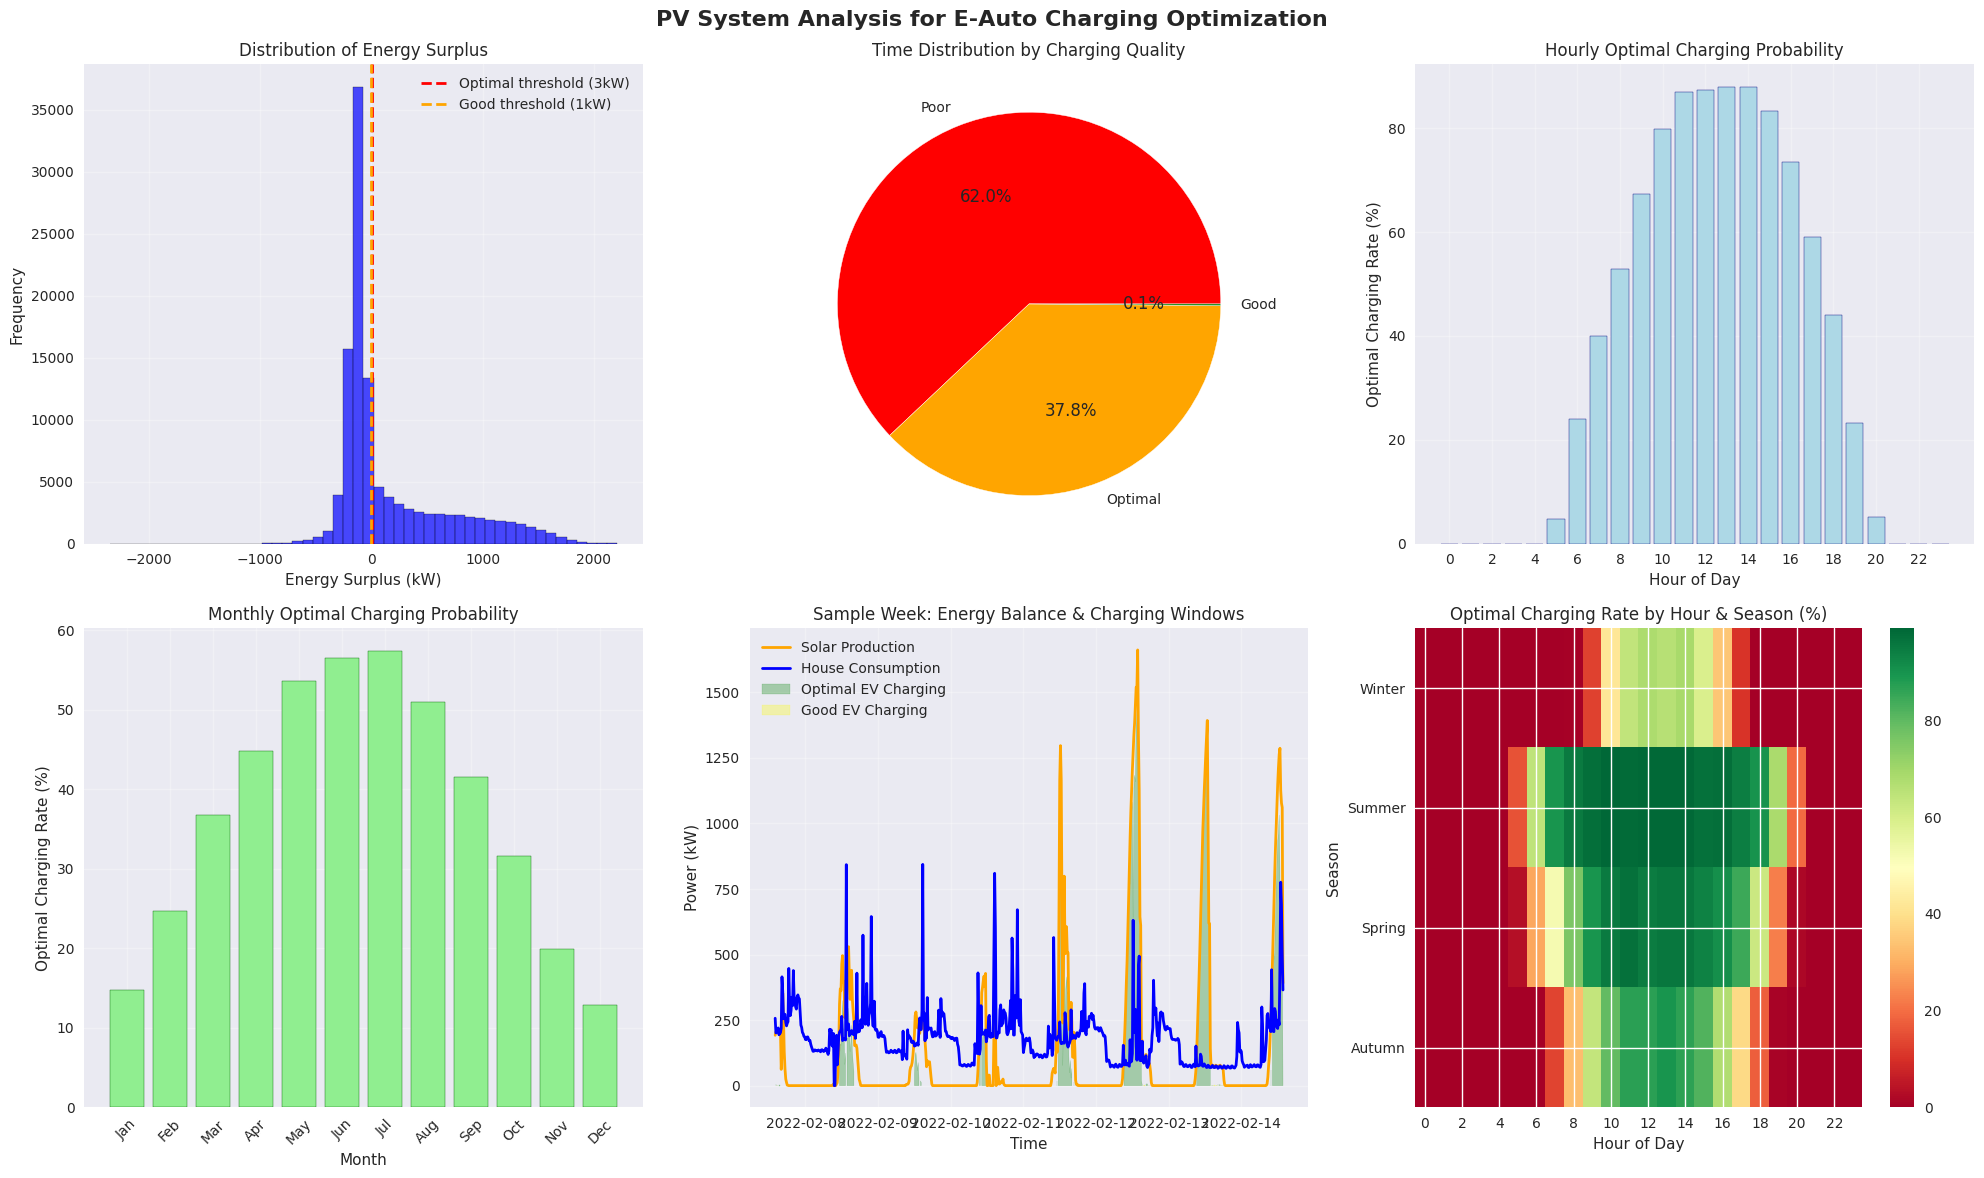

In [10]:
print("\n\n5. 📊 CREATING VISUALIZATIONS")
print("-" * 35)

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('PV System Analysis for E-Auto Charging Optimization', fontsize=16, fontweight='bold')

# 1. Energy surplus distribution
axes[0,0].hist(df['energy_surplus'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0,0].axvline(x=3, color='red', linestyle='--', linewidth=2, label='Optimal threshold (3kW)')
axes[0,0].axvline(x=1, color='orange', linestyle='--', linewidth=2, label='Good threshold (1kW)')
axes[0,0].set_xlabel('Energy Surplus (kW)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Energy Surplus')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Charging quality pie chart
charging_counts = df['charging_quality'].value_counts()
colors = ['red', 'orange', 'green']
axes[0,1].pie(charging_counts.values, labels=charging_counts.index, colors=colors, autopct='%1.1f%%')
axes[0,1].set_title('Time Distribution by Charging Quality')

# 3. Hourly optimal charging rate
hourly_rates = df.groupby('hour')['charging_optimal'].mean() * 100
axes[0,2].bar(hourly_rates.index, hourly_rates.values, color='lightblue', edgecolor='navy')
axes[0,2].set_xlabel('Hour of Day')
axes[0,2].set_ylabel('Optimal Charging Rate (%)')
axes[0,2].set_title('Hourly Optimal Charging Probability')
axes[0,2].set_xticks(range(0, 24, 2))
axes[0,2].grid(True, alpha=0.3)

# 4. Monthly patterns
monthly_rates = df.groupby('month')['charging_optimal'].mean() * 100
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[1,0].bar(range(1, 13), [monthly_rates.get(i, 0) for i in range(1, 13)],
              color='lightgreen', edgecolor='darkgreen')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Optimal Charging Rate (%)')
axes[1,0].set_title('Monthly Optimal Charging Probability')
axes[1,0].set_xticks(range(1, 13))
axes[1,0].set_xticklabels(month_names, rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 5. Daily energy balance pattern (sample week)
sample_week = df.iloc[:7*96]  # First week (assuming 15-min intervals)
axes[1,1].plot(sample_week.index, sample_week['Solarproduktion'], label='Solar Production', color='orange', linewidth=2)
axes[1,1].plot(sample_week.index, sample_week['Hausverbrauch'], label='House Consumption', color='blue', linewidth=2)
axes[1,1].fill_between(sample_week.index, 0, sample_week['energy_surplus'],
                       where=(sample_week['energy_surplus'] >= 3),
                       color='green', alpha=0.3, label='Optimal EV Charging')
axes[1,1].fill_between(sample_week.index, 0, sample_week['energy_surplus'],
                       where=(sample_week['energy_surplus'] >= 1) & (sample_week['energy_surplus'] < 3),
                       color='yellow', alpha=0.3, label='Good EV Charging')
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Power (kW)')
axes[1,1].set_title('Sample Week: Energy Balance & Charging Windows')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. Seasonal comparison
seasonal_data = df.groupby(['season', 'hour'])['charging_optimal'].mean().unstack(level=0) * 100
im = axes[1,2].imshow(seasonal_data.values.T, cmap='RdYlGn', aspect='auto', origin='lower')
axes[1,2].set_xlabel('Hour of Day')
axes[1,2].set_ylabel('Season')
axes[1,2].set_title('Optimal Charging Rate by Hour & Season (%)')
axes[1,2].set_xticks(range(0, 24, 2))
axes[1,2].set_xticklabels(range(0, 24, 2))
axes[1,2].set_yticks(range(4))
axes[1,2].set_yticklabels(['Autumn', 'Spring', 'Summer', 'Winter'])
plt.colorbar(im, ax=axes[1,2])

plt.tight_layout()
plt.show()




# 6. FEATURE ENGINEERING PREVIEW

In [11]:
print("\n\n6. 🔧 FEATURE ENGINEERING PREVIEW")
print("-" * 35)

# Create additional features that could be useful for ML
print("Creating time-based features for ML models...")

# Cyclical encoding of hour and month
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Lag features (if enough data)
if len(df) > 96:  # At least 1 day of data
    df['surplus_lag_1h'] = df['energy_surplus'].shift(4)  # 4 * 15min = 1h
    df['surplus_lag_24h'] = df['energy_surplus'].shift(96)  # 96 * 15min = 24h

# Rolling features
df['surplus_rolling_mean_4h'] = df['energy_surplus'].rolling(window=16).mean()  # 4 hours
df['surplus_rolling_std_4h'] = df['energy_surplus'].rolling(window=16).std()

# Weekend/holiday indicators
df['is_workday'] = ~df['is_weekend']

print("✅ Feature engineering completed!")

# Feature correlation with target
features_to_check = ['hour', 'month', 'is_weekend', 'hour_sin', 'hour_cos',
                     'month_sin', 'month_cos', 'surplus_lag_1h', 'surplus_rolling_mean_4h']

print(f"\n📊 Feature Correlation with Optimal Charging:")
print("   Feature                    | Correlation")
print("   ---------------------------|-------------")

for feature in features_to_check:
    if feature in df.columns:
        corr = df[feature].corr(df['charging_optimal'])
        if not pd.isna(corr):
            print(f"   {feature:<25s} | {corr:8.3f}")



6. 🔧 FEATURE ENGINEERING PREVIEW
-----------------------------------
Creating time-based features for ML models...
✅ Feature engineering completed!

📊 Feature Correlation with Optimal Charging:
   Feature                    | Correlation
   ---------------------------|-------------
   hour                      |    0.123
   month                     |   -0.030
   is_weekend                |    0.008
   hour_sin                  |   -0.115
   hour_cos                  |   -0.714
   month_sin                 |   -0.040
   month_cos                 |   -0.309
   surplus_lag_1h            |    0.722
   surplus_rolling_mean_4h   |    0.700


# 7. SUMMARY AND NEXT STEPS

In [13]:
print("\n\n7. 📋 SUMMARY AND KEY INSIGHTS")
print("-" * 35)

# Calculate key insights
total_optimal_hours = (df['charging_optimal'] == 1).sum() / 4  # Convert 15-min to hours
total_hours = len(df) / 4
optimal_percentage = total_optimal_hours / total_hours * 100

best_season = seasonal_optimal.idxmax()
worst_season = seasonal_optimal.idxmin()

best_hour = hourly_optimal['optimal_rate'].idxmax()
best_hour_rate = hourly_optimal.loc[best_hour, 'optimal_rate'] * 100

print(f"🎯 KEY INSIGHTS FOR E-AUTO CHARGING OPTIMIZATION:")
print(f"   ⚡ Total optimal charging hours available: {total_optimal_hours:,.0f} / {total_hours:,.0f} ({optimal_percentage:.1f}%)")
print(f"   🕐 Best hour for charging: {best_hour:02d}:00 ({best_hour_rate:.1f}% optimal)")
print(f"   🌞 Best season: {best_season} ({seasonal_optimal[best_season]:.1f}% optimal)")
print(f"   ❄️ Worst season: {worst_season} ({seasonal_optimal[worst_season]:.1f}% optimal)")

# Typical charging window
optimal_hours = hourly_optimal[hourly_optimal['optimal_rate'] > 0.5].index  # >50% optimal
if len(optimal_hours) > 0:
    charging_window_start = optimal_hours.min()
    charging_window_end = optimal_hours.max()
    print(f"   ⏰ Typical optimal charging window: {charging_window_start:02d}:00 - {charging_window_end:02d}:00")

print(f"\n🚀 NEXT STEPS FOR ML MODEL DEVELOPMENT:")
print(f"   1. 🎯 Target: Predict optimal charging windows (≥3kW surplus)")
print(f"   2. 🔧 Features: Time-based (hour, month, season) + lag features")
print(f"   3. 🤖 Models: Random Forest, XGBoost, Logistic Regression")
print(f"   4. 📊 Evaluation: Precision/Recall for optimal charging periods")
print(f"   5. ⏰ Prediction horizons: 1h, 6h, 24h ahead")

if wallbox_col in df.columns and active_periods > 0:
    print(f"   6. ✅ Validation: Compare predictions with actual wallbox usage")
else:
    print(f"   6. 📝 Note: No wallbox data available for validation")

print(f"\n💡 PRACTICAL APPLICATION:")
print(f"   🏠 Smart Home: 'Charge EV tomorrow 11:00-15:00 for optimal solar usage'")
print(f"   💰 Cost Savings: Reduce grid electricity consumption for EV charging")
print(f"   🌱 Environmental: Maximize direct solar energy utilization")

print(f"\n" + "="*60)
print(f"✅ Data exploration completed! Ready for ML model development.")
print(f"📊 Dataset prepared with {len(df):,} records and engineered features.")
print(f"🎯 Clear target: {(df['charging_optimal']==1).sum():,} optimal charging periods identified.")
print(f"="*60)



7. 📋 SUMMARY AND KEY INSIGHTS
-----------------------------------
🎯 KEY INSIGHTS FOR E-AUTO CHARGING OPTIMIZATION:
   ⚡ Total optimal charging hours available: 10,761 / 28,450 (37.8%)
   🕐 Best hour for charging: 13:00 (88.0% optimal)
   🌞 Best season: Summer (55.0% optimal)
   ❄️ Worst season: Winter (17.8% optimal)
   ⏰ Typical optimal charging window: 08:00 - 17:00

🚀 NEXT STEPS FOR ML MODEL DEVELOPMENT:
   1. 🎯 Target: Predict optimal charging windows (≥3kW surplus)
   2. 🔧 Features: Time-based (hour, month, season) + lag features
   3. 🤖 Models: Random Forest, XGBoost, Logistic Regression
   4. 📊 Evaluation: Precision/Recall for optimal charging periods
   5. ⏰ Prediction horizons: 1h, 6h, 24h ahead
   6. ✅ Validation: Compare predictions with actual wallbox usage

💡 PRACTICAL APPLICATION:
   🏠 Smart Home: 'Charge EV tomorrow 11:00-15:00 for optimal solar usage'
   💰 Cost Savings: Reduce grid electricity consumption for EV charging
   🌱 Environmental: Maximize direct solar energ